In [1]:
!pip uninstall opentelemetry-sdk opentelemetry-exporter-otlp opentelemetry-api -y --quiet
!pip install --upgrade opentelemetry-sdk opentelemetry-exporter-otlp --quiet
!pip install chromadb umap-learn torch sentence-transformers numpy scikit-learn seaborn matplotlib plotly tqdm --quiet

# XAI: Dense Embeddings

Semantic search is a fundamental part of modern information systems. It leverages **dense embeddings** to capture semantic similarity, which helps find relevant documents even when the exact words differ.

Embedding-based approaches operate in high-dimensional vector spaces which makes these models challenging to interpret.

This notebook combines various **XAI methods** to try to explain these black boxes:  
- **Local explanations** such as Token Leave-Out, Synonym Replacement, and a LIME variant adapted for retrieval tasks.  
- **Global structure analysis** using UMAP clustering and document-to-concept heatmaps.

Together, these methods offer both **pointwise explanations** for individual query-document pairs as well as insights into the **global structure** of the embedding space.


In [2]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
from sentence_transformers import SentenceTransformer

model_id = "all-MiniLM-L6-v2"
model = SentenceTransformer("all-MiniLM-L6-v2").to(device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


# Data/ Vector Store

A custom dataset was created consisting of short text passages from four topics (**Physics**, **Biology**, **Technology**, and **History**). The decision to use a self-constructed dataset was driven by methodological considerations to optimally demonstrate the XAI methods.

The chosen disciplines **differ thematically** from each other, thus forming clearly separable clusters in the embedding space. At the same time, a slight overlap between the fields of Technology and History was introduced, since technological developments are often described within historical contexts.


In [4]:

physics = [
    "Albert Einstein formulated the theory of relativity in the early 20th century.",
    "Newton's laws of motion revolutionized our understanding of physics in the 17th century.",
    "Quantum mechanics was developed by physicists like Heisenberg and Schrödinger in the 1920s.",
    "Einstein's famous equation E=mc² demonstrates the equivalence of mass and energy.",
    "The photoelectric effect discovery earned Einstein the Nobel Prize in Physics in 1921.",
    "Niels Bohr proposed the atomic model that explained electron behavior around the nucleus.",
    "Stephen Hawking studied black holes and made groundbreaking contributions to cosmology.",
    "The uncertainty principle states that position and momentum cannot be measured simultaneously.",
    "General relativity predicts that massive objects bend spacetime around them.",
    "Marie Curie conducted pioneering research on radioactivity and discovered polonium and radium.",
    "The double-slit experiment demonstrates the wave-particle duality of light and matter.",
]

biology = [
    "Charles Darwin published his theory of evolution by natural selection in 1859.",
    "DNA contains the genetic instructions for all living organisms on Earth.",
    "Gregor Mendel discovered the fundamental laws of inheritance through pea plant experiments.",
    "The cell theory states that all living things are composed of one or more cells.",
    "Photosynthesis allows plants to convert sunlight into chemical energy for growth.",
    "Watson and Crick determined the double helix structure of DNA in 1953.",
    "Mitosis is the process by which cells divide to create identical daughter cells.",
    "The human genome contains approximately 3 billion DNA base pairs across 23 chromosomes.",
    "Evolution explains the diversity of life through gradual changes over millions of years.",
    "Enzymes are biological catalysts that speed up chemical reactions in living organisms.",
]

history = [
    "The Neolithic Revolution occurred around 10,000–8,000 BCE in the Fertile Crescent.",
    "Cuneiform writing emerged in ancient Mesopotamia by the late 4th millennium BCE.",
    "Classical Athens advanced democratic institutions in the 5th century BCE.",
    "The Roman Empire reached its greatest extent under Trajan around 117 CE.",
    "The Islamic Golden Age spanned roughly the 8th to 13th centuries.",
    "The Mongol Empire unified vast parts of Eurasia in the 13th century.",
    "The Renaissance revitalized art, science, and humanism from the 14th to 17th centuries.",
    "The American Revolution (1776) and French Revolution (1789) reshaped politics.",
    "The Industrial Revolution mechanized production in the late 18th and 19th centuries.",
    "World War II ended in 1945, reshaping the international order.",
]

technology = [
    "Movable-type printing emerged in Europe in the mid-15th century.",
    "The steam engine catalyzed industrialization in the 18th century.",
    "Telegraph networks enabled rapid long-distance communication in the 19th century.",
    "Electrification transformed cities and industry in the late 19th century.",
    "Internal combustion engines powered cars and planes in the early 20th century.",
    "The transistor, invented in 1947, enabled modern electronics.",
    "ARPANET launched in 1969 as a precursor to the Internet.",
    "The World Wide Web spread globally in the 1990s.",
    "Genome sequencing advances accelerated biotech in the 2000s.",
    "Machine learning advances expanded AI applications in the 2010s–2020s.",
]

physics = [{"text": d, "label": "Physics"} for d in physics]
biology = [{"text": d, "label": "Biology"} for d in biology]
history = [{"text": d, "label": "History"} for d in history]
technology = [{"text": d, "label": "Technology"} for d in technology]

documents = physics + biology + history + technology

In [5]:
import chromadb

collection_name = "xai"
client = chromadb.Client()
metric = "cosine"
collection = client.get_or_create_collection(
    name=collection_name,
    configuration={
        "hnsw": {
            "space": metric,
            "ef_construction": 200
        }
    }
)

In [6]:
doc_embeddings = model.encode([d["text"] for d in documents], normalize_embeddings=True).tolist()

documents = [{"vector": v} | d for d, v in zip(documents, doc_embeddings)]

collection.add(
    ids=[str(i) for i in range(len(doc_embeddings))],
    documents=[d["text"] for d in documents],
    embeddings=doc_embeddings,
    metadatas=[{"label": d["label"]} for d in documents]
)

In [7]:
query = "famous physicists and their contributions"

query_embedding = model.encode(query, normalize_embeddings=True).tolist()
res = collection.query(query_embedding, n_results=10, include=["embeddings", "documents", "distances", "metadatas"])
res

{'ids': [['6', '2', '4', '1', '0', '3', '9', '11', '13', '10']],
 'embeddings': [array([[-4.14007790e-02,  2.16717627e-02, -1.08505844e-03, ...,
          -4.46190611e-02,  2.61495472e-03,  1.40560716e-02],
         [-1.15475934e-02,  1.69467758e-02, -6.23083264e-02, ...,
           1.99484546e-02,  1.69039872e-02,  6.13281839e-02],
         [-9.31872427e-02,  1.00586861e-01, -3.00539061e-02, ...,
          -4.78571020e-02, -6.92625046e-02,  2.25894805e-02],
         ...,
         [-5.07243238e-02,  5.53676449e-02,  1.19442130e-02, ...,
           6.23587705e-02,  3.17521468e-02,  5.55558540e-02],
         [-7.50079751e-02,  4.24699970e-02,  1.42873917e-02, ...,
           1.44666722e-02,  7.30443522e-02, -5.70261254e-05],
         [-7.11106881e-02, -3.79753858e-02,  6.27442170e-03, ...,
           2.14042850e-02,  4.78801876e-03,  2.19497830e-02]])],
 'documents': [['Stephen Hawking studied black holes and made groundbreaking contributions to cosmology.',
   'Quantum mechanics was dev

In [8]:
def unpack_results(results: dict) -> list[dict]:
    combined = list()
    combined = [{"document": doc, "score": score, "label": meta["label"], "vector": vec} for doc, score, meta, vec in zip(results["documents"][0], results["distances"][0], results["metadatas"][0], results["embeddings"][0])]
    if metric == "cosine" or metric == "ip":
        # Highest score (similarity) on top
        return sorted(combined, key=lambda x: x["score"], reverse=True)
    else:
        # Lowest score (distance) on top
        return sorted(combined, key=lambda x: x["score"], reverse=False)

# Token Leave-out (Direct Token Importance)

The Token Leave-Out method examines how much the similarity score decreases when a specific token is removed. The basic assumption is that tokens crucial for the semantic representation significantly affect the similarity score, while less relevant tokens have little impact.

A key methodological aspect is the timing of token removal. Here, the token is removed before the embedding computation,  before the transformer's self-attention mechanism. This ensures that the removed token does not influence the contextual representations of the other tokens. Thus, the measured effect reflects the token's actual contribution to the overall semantic context of the sentence.


In [9]:
import numpy as np
from sentence_transformers import util

In [10]:
def mean_pooling(token_embeddings, attention_mask):
    """Compute mean pooling for token embeddings using an attention mask."""
    mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size())
    return (token_embeddings * mask_expanded).sum(0) / mask_expanded.sum(0)

In [11]:
def normalize_scores(scores: dict) -> dict:
    """Normalize scores using z-score."""
    # Convert values to numpy array for calculation
    vals = np.array(list(scores.values()), dtype=float)

    # Mean of the scores
    mu = vals.mean()
    # Standard deviation
    sigma = vals.std() if vals.std() > 1e-8 else 1.0
    return {tok: float((v - mu) / sigma) for tok, v in scores.items()}


In [12]:
def build_leave_out_token_subset(text: str) -> list[dict[str, str]]:
    # Tokenize the input text into WordPiece tokens
    toks = model.tokenizer.tokenize(text)
    subsets = []
    # Iterate over tokens with their indices
    for i, tok in enumerate(toks):
        # Keep all tokens except the i-th one (simulate leaving this token out)
        kept = [t for k, t in enumerate(toks) if k != i]
        # Convert the remaining token list back into a text string
        removed_text = model.tokenizer.convert_tokens_to_string(kept)
        subsets.append({"text": removed_text, "token": tok})
    return subsets

In [13]:
from tqdm import tqdm


def token_importance(query, documents) -> list[dict[str, dict[str, float]]]:
    embedded_query = model.encode(query, normalize_embeddings=True) # query embedding
    document_embeddings = model.encode(documents, normalize_embeddings=True) # document embeddings

    full_similarities = util.cos_sim(embedded_query, document_embeddings).tolist()[0] # query to document similarities

    # Create Leave-out Sublists
    leave_out_docs = [build_leave_out_token_subset(doc) for doc in documents]
    leave_out_query = build_leave_out_token_subset(query)


    # Result
    token_importance: list[dict[str, dict[str, float]]] = list()

    for doc_subsets, doc_emb, full_sim in tqdm(zip(leave_out_docs, document_embeddings, full_similarities), total=len(leave_out_docs)):

        # Document Tokens -> Query
        doc_token_importance: dict[str, float] = dict()
        for item in doc_subsets:
            masked_text = item["text"]
            masked_token = item["token"]
            sub_embedding = model.encode(masked_text, normalize_embeddings=True)
            # Compute similarity between query embedding and masked document embedding
            sub_sim = util.cos_sim(sub_embedding, query_embedding).item()
            doc_token_importance[masked_token] = full_sim - sub_sim

        # Query Tokens -> Document
        query_token_importance: dict[str, float] = dict()
        for item in leave_out_query:
            masked_text = item["text"]
            masked_token = item["token"]
            sub_embedding = model.encode(masked_text, normalize_embeddings=True)
            # Compute similarity between masked query and the current document embedding
            sub_sim = util.cos_sim(sub_embedding, doc_emb).item()
            query_token_importance[masked_token] = full_sim - sub_sim

        doc_token_importance = normalize_scores(doc_token_importance)
        query_token_importance = normalize_scores(query_token_importance)
        token_importance.append({
            "document": doc_token_importance,
            "query": query_token_importance
        })

    return token_importance

In [14]:
import matplotlib.pyplot as plt

def plot_influence(results, title, sharey=True):
    n = len(results)
    fig, axes = plt.subplots(nrows=n, ncols=2, figsize=(12, 4 * n), squeeze=False)

    for i, res in tqdm(enumerate(results), total=len(results), desc="Creating Plots"):
        doc_contrib = res["document"]
        qry_contrib = res["query"]

        ax_left = axes[i, 0]
        ax_right = axes[i, 1]

        # Document
        ax_left.bar(list(doc_contrib.keys()), list(doc_contrib.values()), color="#4c78a8")
        ax_left.axhline(0, color="black", linewidth=0.8)
        ax_left.set_title("Document")
        ax_left.set_ylabel("Influence")
        ax_left.tick_params(axis="x", rotation=75)

        # Query
        ax_right.bar(list(qry_contrib.keys()), list(qry_contrib.values()), color="#f58518")
        ax_right.axhline(0, color="black", linewidth=0.8)
        ax_right.set_title("Query")
        ax_right.tick_params(axis="x", rotation=45)

        if sharey:
            ymin = min(min(doc_contrib.values(), default=0), min(qry_contrib.values(), default=0))
            ymax = max(max(doc_contrib.values(), default=0), max(qry_contrib.values(), default=0))
            pad = 0.05 * (ymax - ymin if ymax > ymin else 1.0)
            ax_left.set_ylim(ymin - pad, ymax + pad)
            ax_right.set_ylim(ymin - pad, ymax + pad)

    fig.suptitle(title, y=0.995)
    fig.tight_layout()
    return fig

Creating Plots: 100%|██████████| 10/10 [00:00<00:00, 28.98it/s]


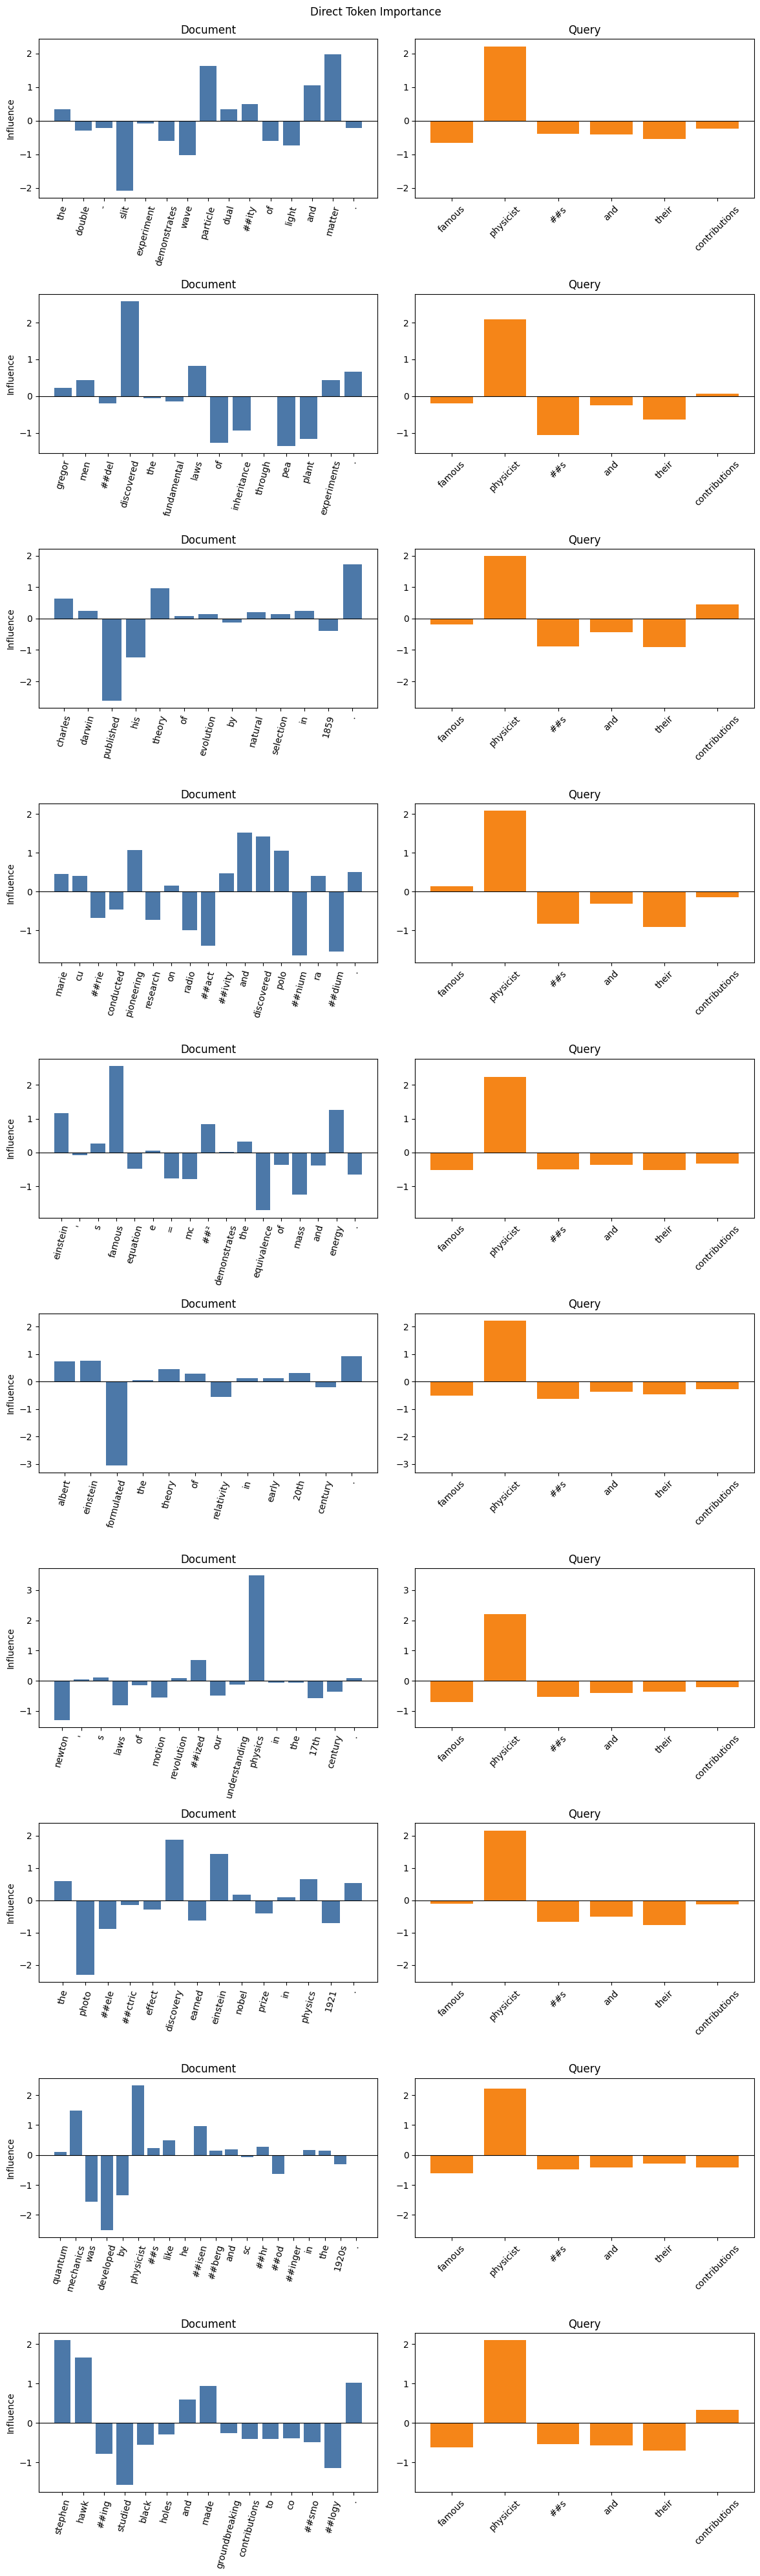

In [15]:
results = unpack_results(res)
importance = token_importance(query, [r["document"] for r in results])

figure = plot_influence(importance, "Direct Token Importance")
figure.show()

# Synonym Replacement

Besides removing tokens, synonym replacement offers a way to examine the robustness of embedding-based representations against linguistic variation. While the leave-out method measures a token's influence on the overall context, synonym replacement answers whether the model truly captures the semantic meaning of a word or is more strongly tied to its specific word form.

For a given token, a set of potential synonyms is obtained using WordNet. To improve the quality of these candidates, linguistic preprocessing is applied:  
1. Part-of-speech (PoS) tagging is used to determine the word type of a token.  
2. Then, the token is lemmatized to its base form to avoid including synonyms of incorrect word classes.

Synonyms corresponding to the lemmatized form are extracted from WordNet and used as replacement candidates.


In [16]:
def _tokenize_with_offsets(text: str):
    """Tokenize a text into WordPiece tokens and provide character-level offsets."""

    # Use the model's tokenizer to get token IDs and character-level spans per token
    enc = model.tokenizer(text, return_offsets_mapping=True, add_special_tokens=False)
    # Convert token IDs back to (WordPiece) string tokens
    tokens = model.tokenizer.convert_ids_to_tokens(enc["input_ids"])
    # Build a list of (start_char, end_char) offsets for each token (for easy replacement)
    offsets = [(int(s), int(e)) for (s, e) in enc["offset_mapping"]]
    return tokens, offsets

def _replace_span(text: str, start_char: int, end_char: int, replacement: str) -> str:
    """Replace a substring of text specified by character offsets with a replacement string."""
    return text[:start_char] + replacement + text[end_char:]


In [17]:
import nltk
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer

nltk.download('punkt'); nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet'); nltk.download('omw-1.4')
nltk.download('punkt_tab')

_lemmatizer = WordNetLemmatizer()

def _nltk_pos_to_wn(pos_tag: str):
    """Convert an NLTK POS tag to a WordNet POS constant."""
    c = pos_tag[0].upper() if pos_tag else ''
    return {'J': wn.ADJ, 'N': wn.NOUN, 'V': wn.VERB, 'R': wn.ADV}.get(c, None)

def _pos_tag_words(raw_text: str):
    """Tokenize a text into words (not WordPiece) and assign part-of-speech tags."""
    toks = nltk.word_tokenize(raw_text)
    return nltk.pos_tag(toks)

def get_wordnet_synonyms(word: str, pos_tag: str|None=None, top_k:int=5) -> list[str]:
    """Retrieve candidate synonyms for a given word from WordNet."""

    # Convert NLTK POS tag to WordNet POS
    wn_pos = _nltk_pos_to_wn(pos_tag) if pos_tag else None
    # Lemmatize
    lemma = _lemmatizer.lemmatize(word, wn_pos) if wn_pos else _lemmatizer.lemmatize(word)
    # Retrieve WordNet synsets for the lemma
    synsets = wn.synsets(lemma, pos=wn_pos) if wn_pos else wn.synsets(lemma)

    # Collect unique lemma names across synsets
    syns = set()
    for s in synsets:
        for l in s.lemmas():
            syns.add(l.name().replace('_', ' '))
    # Exclude the original word itself
    syns = [s for s in syns if s.lower() != word.lower()]
    # Prefer single-word
    syns = sorted(syns, key=lambda x: (len(x.split()), len(x)))[:top_k]
    return syns


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [18]:
import re

def build_synonym_variants_with_offsets(text: str):
    """Build text variants by replacing tokens with synonyms (WordNet-based)."""

    # Tokenize into WordPiece tokens and get character spans
    tokens, token_spans = _tokenize_with_offsets(text)
    # POS-tag words at surface level (not WordPiece level)
    word_pos_tags = _pos_tag_words(text)

    synonym_variants = []

    # Iterate over each token with its character span
    for token, (start_char, end_char) in zip(tokens, token_spans):
        original_word = text[start_char:end_char]

        # Find the best POS tag for this token (based on overlap with word spans)
        best_pos_tag = None
        max_overlap = 0
        search_cursor = 0

        for word, pos_tag in word_pos_tags:
            # Try to find this word in the text starting at the cursor
            match = re.search(rf'\b{re.escape(word)}\b', text[search_cursor:])
            if not match:
                search_cursor += len(word)
                continue

            word_start = search_cursor + match.start()
            word_end = search_cursor + match.end()

            # Calculate overlap between WordPiece span and surface word span
            overlap = max(0, min(word_end, end_char) - max(word_start, start_char))

            if overlap > max_overlap:
                max_overlap = overlap
                best_pos_tag = pos_tag

            # Move cursor to the end of this word
            search_cursor = word_end

        # Get synonyms for the original word using WordNet
        candidate_synonyms = get_wordnet_synonyms(original_word, best_pos_tag, top_k=3)

        # Build variants by replacing the token span with each synonym
        for synonym in candidate_synonyms:
            replaced_text = _replace_span(text, start_char, end_char, synonym)

            synonym_variants.append({
                "text": replaced_text,
                "token": original_word,
                "synonym": synonym,
                "span": (start_char, end_char),
                "type": "synonym"
            })

    return synonym_variants


In [19]:
def synonym_importance(query: str, documents: list[str]):
    """Evaluate the effect of synonym replacement on query-document similarity."""
    q_emb = model.encode(query, normalize_embeddings=True)
    d_embs = model.encode(documents, normalize_embeddings=True)

    # Baseline cosine similarities between query and each document
    base_sims = util.cos_sim(q_emb, d_embs).tolist()[0]

    # Precompute synonym-perturbed variants
    syn_docs  = [build_synonym_variants_with_offsets(doc) for doc in documents]
    syn_query = build_synonym_variants_with_offsets(query)

    results = []
    for idx, (doc, d_emb, base_sim) in enumerate(zip(documents, d_embs, base_sims)):
        # Document Synonym Replacement
        doc_imp = {}
        pairs_doc = []
        for item in syn_docs[idx]:
            sub_emb = model.encode(item["text"], normalize_embeddings=True)
            sub_sim = util.cos_sim(q_emb, sub_emb).item()
            delta = base_sim - sub_sim
            key = f'{item["token"]}->{item["synonym"]}'
            doc_imp[key] = float(delta)
            pairs_doc.append((item["token"], item["synonym"], float(delta)))

        # Query Synonym Replacement
        query_imp = {}
        pairs_query = []
        for item in syn_query:
            sub_emb = model.encode(item["text"], normalize_embeddings=True)
            sub_sim = util.cos_sim(sub_emb, d_emb).item()
            delta = base_sim - sub_sim
            key = f'{item["token"]}->{item["synonym"]}'
            query_imp[key] = float(delta)
            pairs_query.append((item["token"], item["synonym"], float(delta)))

        results.append({
            "document": doc_imp,
            "query": query_imp,
            "pairs_doc": pairs_doc,
            "pairs_query": pairs_query
        })
    return results

In [20]:
def plot_synonym_effects(doc_imp: dict, query_imp: dict, query: str, document: str,  title: str = ""):

    di = sorted(doc_imp.items(), key=lambda x: x[1], reverse=True)[:15]
    qi = sorted(query_imp.items(), key=lambda x: x[1], reverse=True)[:15]

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    colors_doc = ["red" if v > 0 else "green" for _, v in di]
    axes[0].bar([k for k,_ in di], [v for _,v in di], color=colors_doc)
    axes[0].set_title(f"Document:\n{document}")
    axes[0].tick_params(axis='x', rotation=90)
    axes[0].axhline(0, color="black", linewidth=0.8)

    colors_query = ["red" if v > 0 else "green" for _, v in qi]
    axes[1].bar([k for k,_ in qi], [v for _,v in qi], color=colors_query)
    axes[1].set_title(f"Query:\n{query}")
    axes[1].tick_params(axis='x', rotation=90)
    axes[1].axhline(0, color="black", linewidth=0.8)

    fig.suptitle(title)
    fig.tight_layout()
    plt.show()

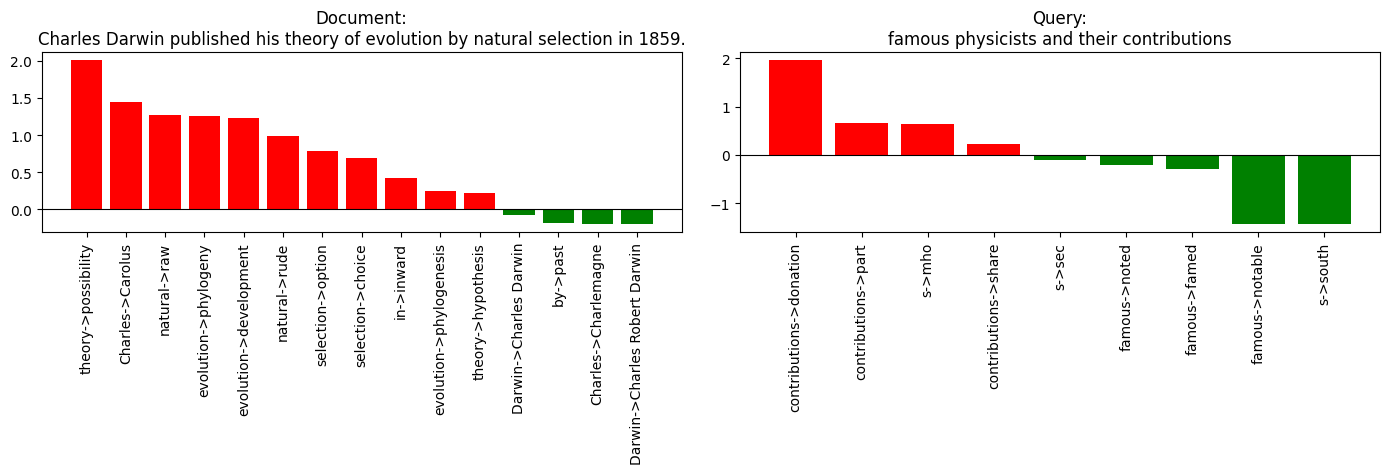

In [21]:
syn_res = synonym_importance(query, [r["document"] for r in results])

doc_imp_syn  = syn_res[2]["document"]
query_imp_syn = syn_res[2]["query"]

doc_imp_syn  = normalize_scores(doc_imp_syn)
query_imp_syn = normalize_scores(query_imp_syn)

plot_synonym_effects(doc_imp_syn, query_imp_syn, query=query, document=results[2]["document"])


# Lime

The core idea behind LIME (Local Interpretable Model-agnostic Explanations) is to provide a local explanation for a specific prediction of a complex black-box model. This is done by generating many slightly altered variants (perturbations) of the input in the vicinity of the original data point and computing the black-box model's outputs on these variants to create a set of labeled data points.

A simple surrogate model (here a linear regression) is then trained on these perturbed samples and their corresponding outputs. This surrogate model does not replace the black-box model but approximates its behavior locally around the specific instance. The coefficients of this surrogate model are interpretable and reveal which input features were most influential for the prediction in the given context.

To transfer the standard LIME approach to a retrieval problem, a query-document pair is selected as the local data point around which perturbations are generated. These perturbations are created by randomly removing individual tokens, resulting in numerous variants of the document (and query), each differing by the absence of certain words. These variants can be represented by binary masks where *1* means the token is kept and *0* means it is removed. Starting from the original mask with all tokens included, random subsets of tokens are removed to generate the perturbations.

Instead of classification probabilities, the cosine similarity between the query embedding and the document embedding is used as the target value to explain, showing how individual tokens contribute to the similarity score in semantic search.


In [22]:
def extract_core_tokens(tokens: list[str]) -> slice:
    """Returns the core Tokens Sequence. Removes start [CLS] and end [SEP] token."""
    if len(tokens) >= 2:
        return slice(1, len(tokens) - 1) # exclude first and last token
    return slice(0, len(tokens))

In [23]:
def sample_masks(n_core: int, n_samples: int, keep_prob: float = 0.8, max_flips: int = 3) -> np.ndarray:
    rng = np.random.default_rng(42)
    masks = []
    for _ in range(n_samples):
        m = (rng.random(n_core) < keep_prob).astype(np.int32)
        flips = rng.integers(low=0, high=max_flips + 1)
        if flips > 0 and n_core > 0:
            idx = rng.choice(n_core, size=min(flips, n_core), replace=False)
            m[idx] = 1 - m[idx]
        if m.sum() == 0 and n_core > 0:
            m[rng.integers(0, n_core)] = 1
        masks.append(m)
    return np.stack(masks, axis=0)

In [24]:
def hamming_distance(m1: np.ndarray, m2: np.ndarray) -> int:
    """Compute Hamming distance between two binary masks."""
    return int(np.sum(m1 != m2))

def lime_kernel(dist: float, sigma: float) -> float:
    """Kernel function to weight samples based on their distance."""
    return float(np.exp(-(dist**2) / (sigma**2)))

In [25]:
from sklearn.linear_model import LinearRegression


def lime(query: str, document: str, n_samples: int = 500, sigma: float = 1.0, keep_prob: float = 0.85, max_flips: int = 2) -> dict[str, dict[str, float]]:
    """Apply LIME to explain query-document similarity."""

    # Query
    query_encoded = model.tokenize([query]) # input_ids +  attention_mask
    query_tokens = model.tokenizer.convert_ids_to_tokens(query_encoded["input_ids"][0]) # Tokens (not ids)
    query_attention_mask = query_encoded["attention_mask"][0]
    query_token_embedding = model.encode(query, normalize=True, output_value="token_embeddings").cpu()
    query_embedding = mean_pooling(query_token_embedding, query_attention_mask)

    # Document
    doc_encoded = model.tokenize([document])
    doc_tokens = model.tokenizer.convert_ids_to_tokens(doc_encoded["input_ids"][0])
    doc_attention_mask = doc_encoded["attention_mask"][0]
    doc_token_embedding = model.encode(document, normalize=True, output_value="token_embeddings").cpu()
    doc_embedding = mean_pooling(doc_token_embedding, doc_attention_mask)

    base_score = util.cos_sim(query_embedding, doc_embedding).item()

    # Remove [CLS] and [SEP] Tokens
    query_tokens_core = extract_core_tokens(query_tokens)
    n_core_q = max(0, query_tokens_core.stop - query_tokens_core.start) # Core Query Length (All Tokens without special Tokens)
    document_tokens_core = extract_core_tokens(doc_tokens)
    n_core_d = max(0, document_tokens_core.stop - document_tokens_core.start) # Core Document Length (All Tokens without special Tokens)

    # Query Tokens -> Document
    query_maskset = sample_masks(n_core=n_core_q, n_samples=n_samples, keep_prob=keep_prob, max_flips=max_flips) # Masks for core Query sequence
    q_mask_full = np.ones(len(query_tokens), dtype=np.int32)
    X_q, y_q, w_q = [], [], []
    q_ref_core = np.ones(n_core_q, dtype=np.int32) # All 1 (normal attention_mask), used to fix

    for m_core in query_maskset:
        m_full = q_mask_full.copy()
        m_full[query_tokens_core] = m_core # Apply mask to core token sequence
        attn_mask = torch.tensor(m_full)
        q_subset_emb = mean_pooling(query_token_embedding, attn_mask)
        score = util.cos_sim(q_subset_emb, doc_embedding).item() # Masked Score
        dist = hamming_distance(m_core, q_ref_core)
        weight = lime_kernel(dist, sigma)
        X_q.append(m_core.astype(np.float32))
        y_q.append(score)
        w_q.append(weight)

    X_q = np.asarray(X_q, dtype=np.float32)
    y_q = np.asarray(y_q, dtype=np.float32)
    w_q = np.asarray(w_q, dtype=np.float32)

    reg_q = LinearRegression()
    reg_q.fit(X_q, y_q, sample_weight=w_q)
    q_coefs_core = reg_q.coef_

    # Map Coefs to Tokens
    q_token_importance = {tok: float(coef) for tok, coef in zip(query_tokens[query_tokens_core], q_coefs_core)}

    # Document Tokens -> Query
    d_masks_core = sample_masks(n_core=n_core_d, n_samples=n_samples, keep_prob=keep_prob, max_flips=max_flips) # Masks for core Document sequence
    d_mask_full = np.ones(len(doc_tokens), dtype=np.int32)
    X_d, y_d, w_d = [], [], []
    d_ref_core = np.ones(n_core_d, dtype=np.int32)

    for m_core in d_masks_core:
        m_full = d_mask_full.copy()
        m_full[document_tokens_core] = m_core
        attn_mask = torch.tensor(m_full)
        d_subset_emb = mean_pooling(doc_token_embedding, attn_mask)
        score = util.cos_sim(query_embedding, d_subset_emb).item()
        dist = hamming_distance(m_core, d_ref_core)
        weight = lime_kernel(dist, sigma)
        X_d.append(m_core.astype(np.float32))
        y_d.append(score)
        w_d.append(weight)

    X_d = np.asarray(X_d, dtype=np.float32)
    y_d = np.asarray(y_d, dtype=np.float32)
    w_d = np.asarray(w_d, dtype=np.float32)

    reg_d = LinearRegression()
    reg_d.fit(X_d, y_d, sample_weight=w_d)
    d_coefs_core = reg_d.coef_
    d_token_importance = {tok: float(coef) for tok, coef in zip(doc_tokens[document_tokens_core], d_coefs_core)}

    return {
        "base_score": base_score,
        "query": q_token_importance,
        "document": d_token_importance,
    }

Creating Plots: 100%|██████████| 1/1 [00:00<00:00, 39.23it/s]


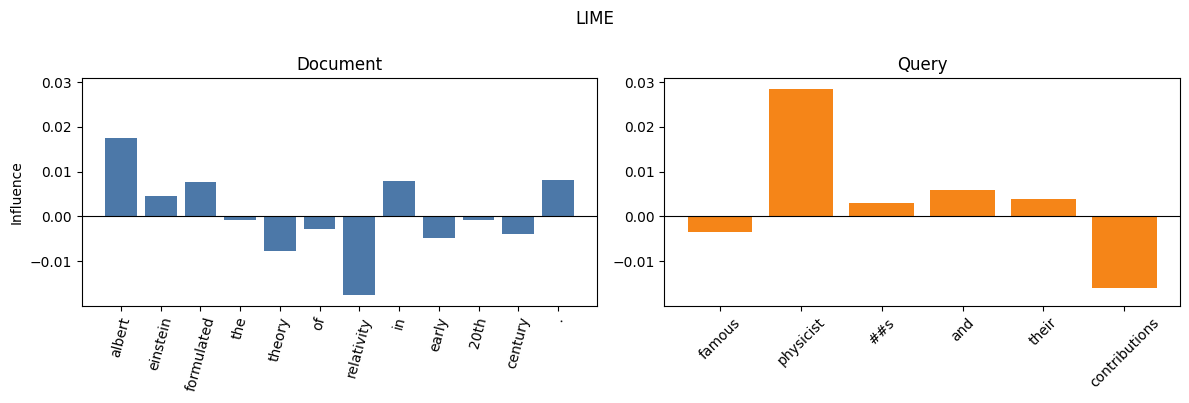

In [26]:
lime_res = lime(query, results[5]["document"])
figure = plot_influence([lime_res], "LIME")
figure.show()

# Clustering with UMAP

To analyze the global structure of the embedding space, document embeddings are projected together with four concept anchors. These anchors correspond to the topic labels of the dataset ("Physics", "Biology", "History", "Technology") and are, like the documents, initially converted into vectors using the sentence embedding model.

Subsequently, all vectors are jointly mapped to two dimensions using UMAP. UMAP (Uniform Manifold Approximation and Projection) is a dimensionality reduction technique that transforms high-dimensional vectors into a low-dimensional projection. Its goal is to preserve local neighborhoods as much as possible, so documents that are close together in the embedding space also appear tightly grouped in the two-dimensional plot.


In [27]:
# Anchor Embeddings
phy = model.encode("Physics")
bio = model.encode("Biology")
hist = model.encode("History")
tech = model.encode("Technology")


In [28]:
import umap

doc_labels = [d["label"] for d in documents]
labels = ["Physics", "Biology", "History", "Technology"]

# Stack document embeddings together with concept anchor embedding
X = np.vstack([doc_embeddings, phy, bio, hist, tech])
reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2, # reduce to 2D for visualization
    metric="cosine", # cosine distance fits embedding similarity
    random_state=42
)
X2 = reducer.fit_transform(X)

# Separate transformed coordinates (for plotting purpose)
doc_X2 = X2[:len(doc_embeddings)]   # coordinates for documents
label_X2 = X2[len(doc_embeddings):] # coordinates for the concept labels

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [29]:
import plotly.graph_objects as go


color_map = {
    "Physics": "#1f77b4",
    "Biology": "#2ca02c",
    "History": "#d62728",
    "Technology": "#9467bd",
}
label_colors = [color_map[lbl] for lbl in labels]
point_colors = [color_map[lbl] for lbl in doc_labels]

hover_text_docs = [
    f"Label: {lbl}<br>Text: {txt}" for lbl, txt in zip(doc_labels, [d["text"] for d in documents])
]

doc_trace = go.Scattergl(
    x=doc_X2[:, 0],
    y=doc_X2[:, 1],
    mode="markers",
    marker=dict(color=point_colors, size=7, line=dict(color="white", width=0.5)),
    text=hover_text_docs,
    hovertemplate="%{text}<extra></extra>",
    name="Documents",
)

label_trace = go.Scattergl(
    x=label_X2[:, 0],
    y=label_X2[:, 1],
    mode="markers+text",
    text=labels,
    textposition="middle center",
    textfont=dict(color=label_colors, size=14, family="Arial Black"),
    marker=dict(color=label_colors, size=12, line=dict(color="black", width=1)),
    hovertemplate="Concept vector: %{text}<extra></extra>",
    name="Concepts",
)

fig = go.Figure(data=[doc_trace, label_trace])
fig.update_layout(
    title=f"UMAP: Document to Conecept - {model_id}",
    xaxis_title="UMAP-1",
    yaxis_title="UMAP-2",
    hovermode="closest",
    template="plotly_white",
)
fig.write_html("umap_concepts.html", include_plotlyjs="cdn")
fig.show()


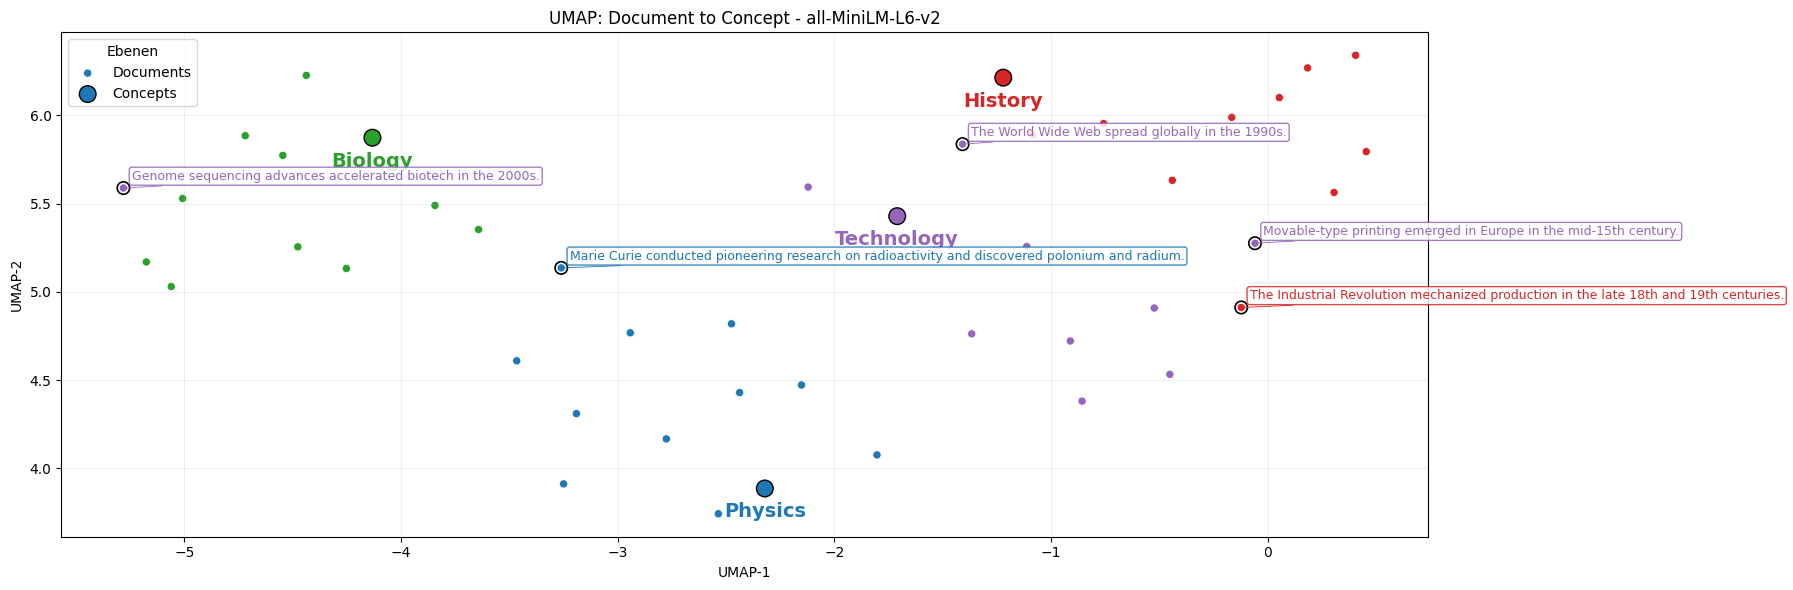

In [30]:

# Colors for each concept label (anchors)
label_colors = [color_map[lbl] for lbl in labels]
point_colors = [color_map[lbl] for lbl in doc_labels]

fig, ax = plt.subplots(figsize=(18, 6))

# Plot documents as small points
doc_sc = ax.scatter(
    doc_X2[:, 0],
    doc_X2[:, 1],
    c=point_colors,
    s=35, # point size
    linewidths=0.5,
    edgecolors="white",
    label="Documents",
)

# Plot concept anchors as larger points
ax.scatter(
    label_X2[:, 0],
    label_X2[:, 1],
    c=label_colors,
    s=144, # point size
    linewidths=1.0,
    edgecolors="black",
    label="Concepts",
)

# Add text labels above concept anchor points
for x, y, lbl, col in zip(label_X2[:, 0], label_X2[:, 1], labels, label_colors):
    ax.annotate(
        lbl,
        xy=(x, y),
        xytext=(0, -10),
        textcoords="offset points",
        ha="center",
        va="top",
        fontsize=14,
        fontweight="bold",
        color=col
    )

# Detect documents that are far from their own label
# Compute L2 distances between each document and each label point
dist = np.linalg.norm(doc_X2[:, None, :] - label_X2[None, :, :], axis=2) # (n_docs, n_labels)


# For each document, find the index of its nearest concept label
nearest_label_idx = np.argmin(dist, axis=1) # (n_docs,)
# Convert the true labels of documents into label indices
label_index_of_doc = np.array([labels.index(lbl) for lbl in doc_labels]) # (n_docs,)

# Boolean mask: documents where predicted nearest label != true label
mask_mismatch = nearest_label_idx != label_index_of_doc # (n_docs,)
idxs = np.flatnonzero(mask_mismatch) # 1D int-Array

# Highlight mismatched documents with a black circle
ax.scatter(
    doc_X2[idxs, 0], doc_X2[idxs, 1],
    facecolors="none", edgecolors="black", s=80, linewidths=1.2, label=None
)

# Annotate mismatched documents with short text
for di in idxs.tolist():
    doc_i = documents[di]
    txt = doc_i["text"] if isinstance(doc_i, dict) and "text" in doc_i else str(doc_i)
    short = (txt[:120] + "…") if len(txt) > 120 else txt

    ax.annotate(
        short,
        xy=(doc_X2[di, 0], doc_X2[di, 1]),
        xytext=(6, 6),
        textcoords="offset points",
        fontsize=9,
        color=color_map[doc_labels[di]],
        bbox=dict(
            boxstyle="round,pad=0.2",
            fc="white",
            alpha=0.85,
            ec=color_map[doc_labels[di]]
        ),
        arrowprops=dict(arrowstyle="-", lw=0.6, color=color_map[doc_labels[di]])
    )

ax.set_title(f"UMAP: Document to Concept - {model_id}")
ax.set_xlabel("UMAP-1")
ax.set_ylabel("UMAP-2")
ax.legend(title="Ebenen")
ax.grid(True, alpha=0.2)

plt.tight_layout()
plt.savefig("umap_concepts.png", dpi=150)
plt.show()


# Document to Concept Similarity

A heatmap of document-to-concept similarities is created based on the cosine similarities between the embeddings of all documents and the previously defined concept vectors "Physics," "Biology," "History," and "Technology."

This results in a matrix where each row represents a document and each column corresponds to a concept. The color intensity indicates how similar a document is to a given concept, with darker colors representing lower similarity and lighter colors representing higher similarity.

The heatmap provides a clear, tabular visualization of the relationships between documents and concepts.

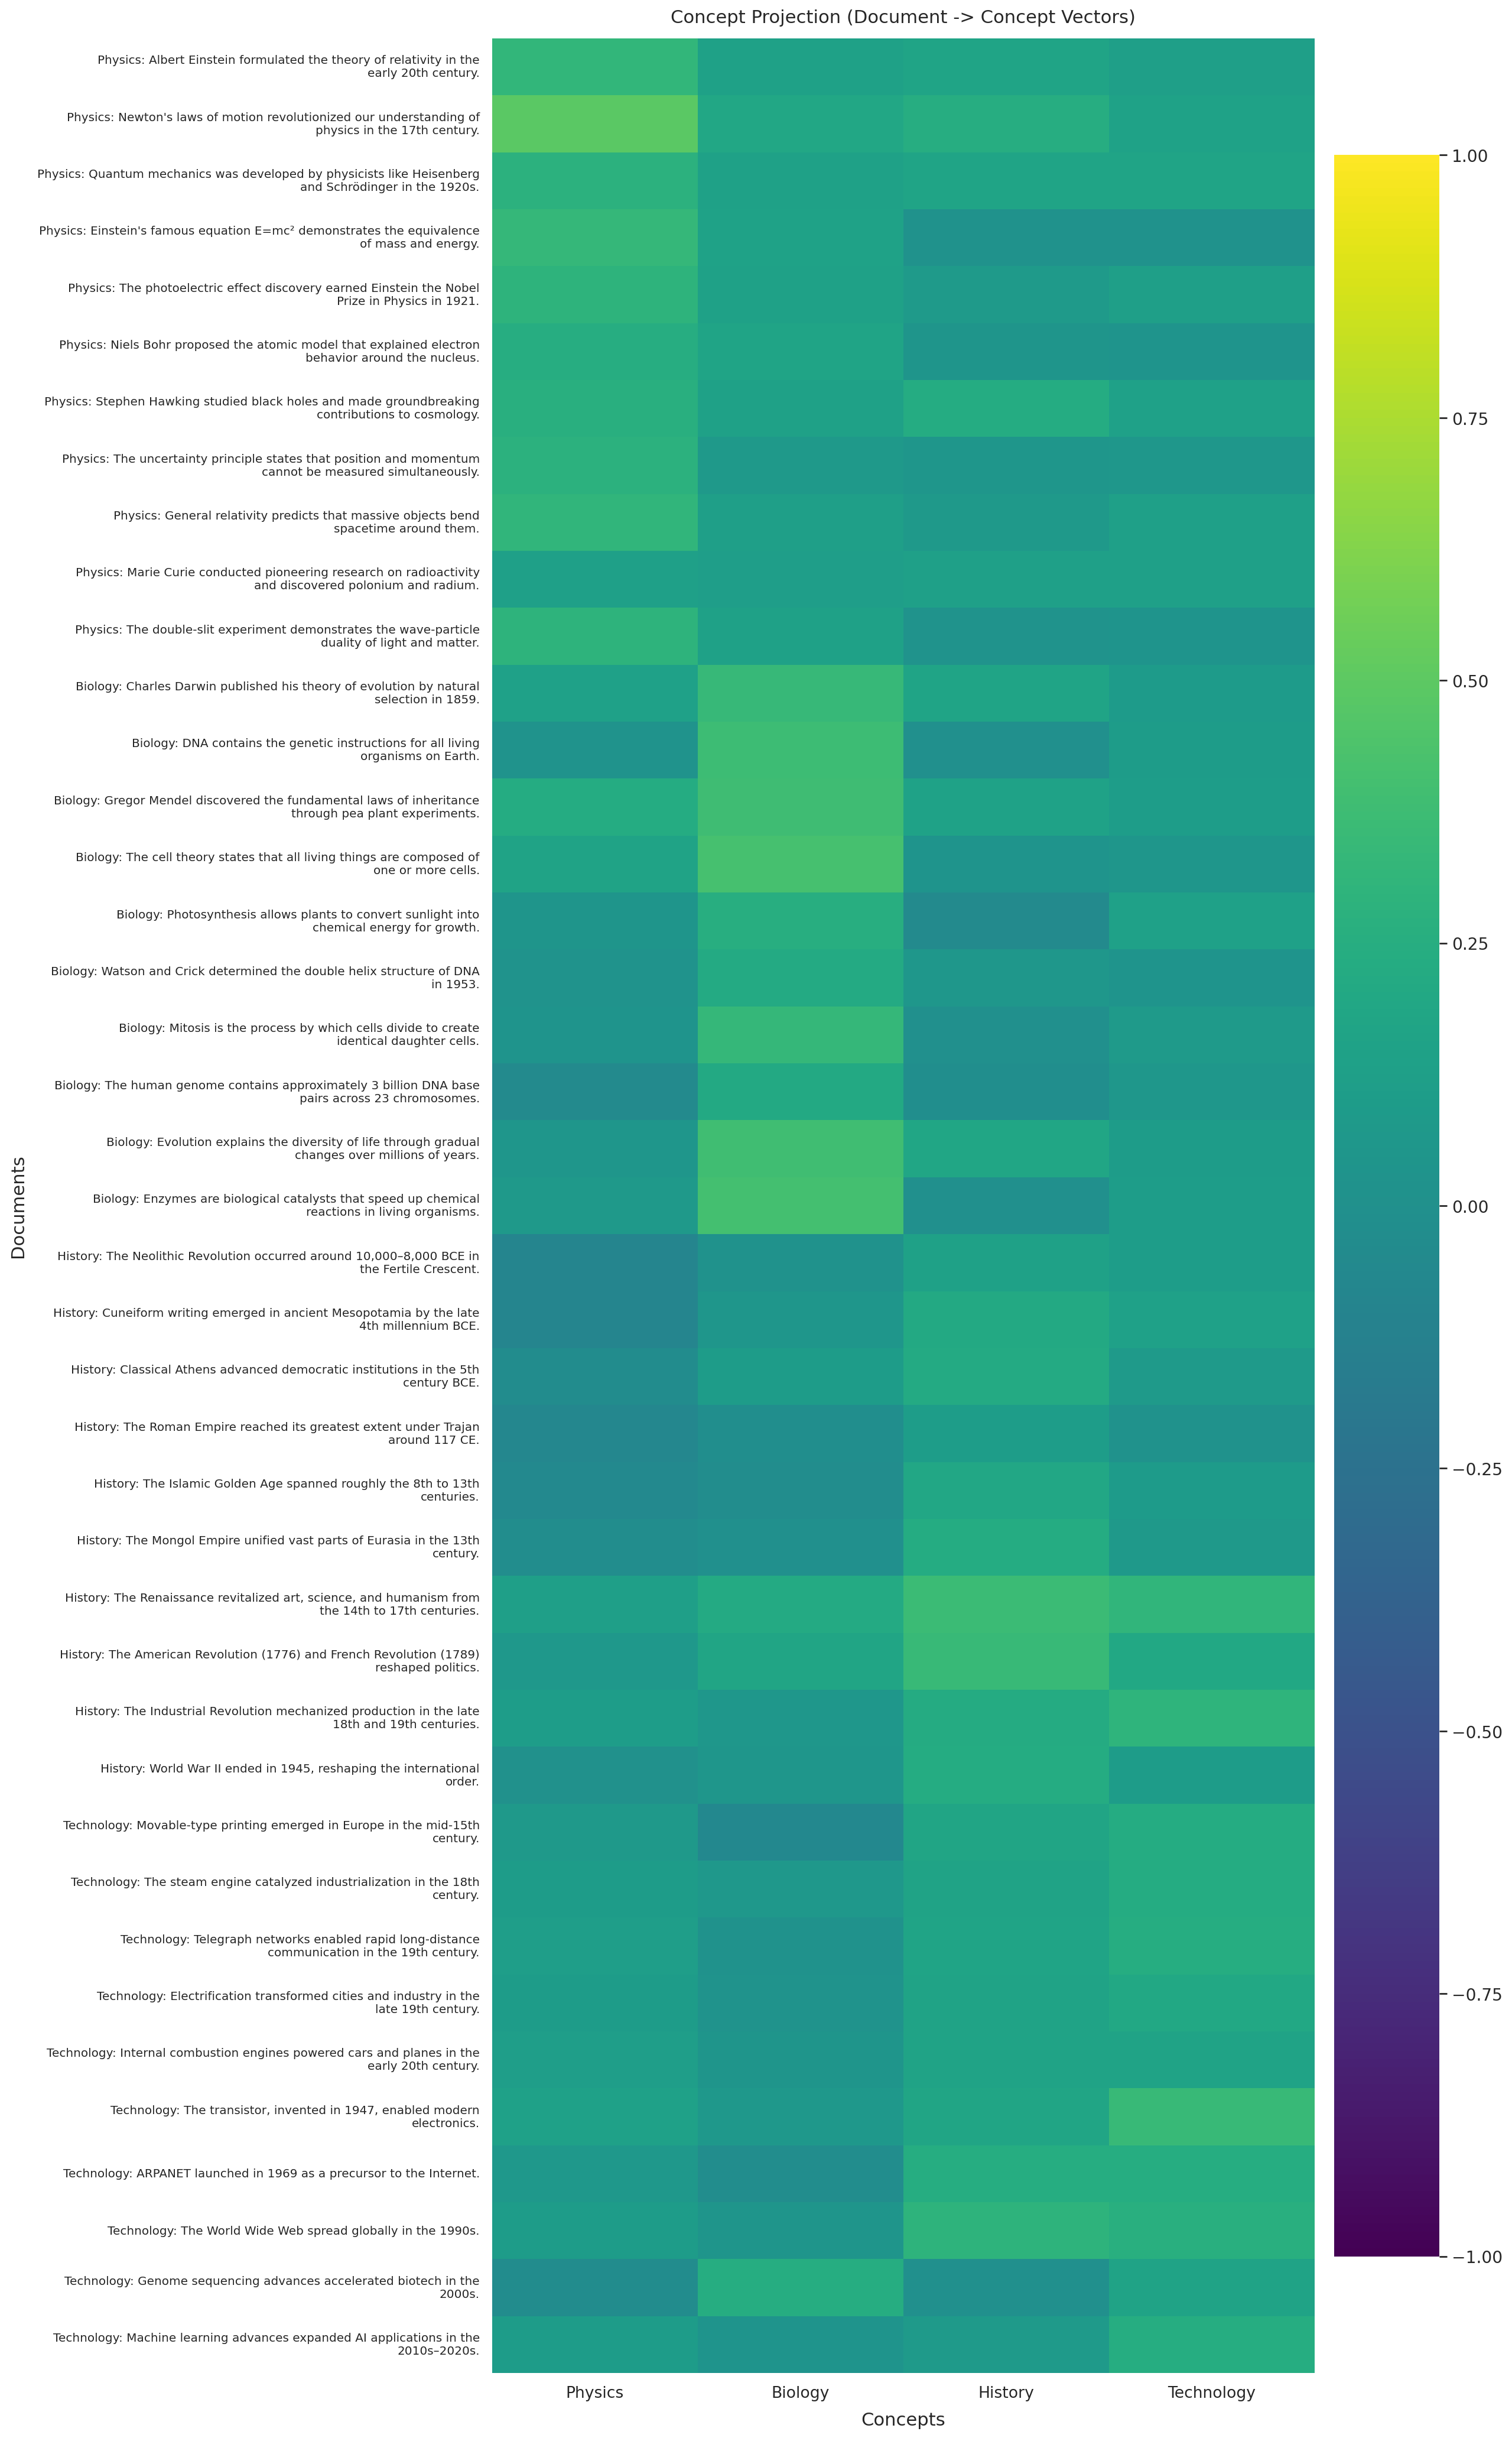

In [31]:
import seaborn as sns
import textwrap


concept_mat = np.vstack([phy, bio, hist, tech])
proj = util.cos_sim(doc_embeddings, concept_mat).detach().cpu().numpy()

ytexts = [textwrap.fill(f"{d['label']}: {d['text']}", width=70) for d in documents]

sns.set(font_scale=1.15)
fig, ax = plt.subplots(figsize=(16, 26), dpi=160)

hm = sns.heatmap(
    proj,
    ax=ax,
    cmap="viridis",
    vmin=-1.0, vmax=1.0,
    xticklabels=labels,
    yticklabels=ytexts,
    annot=False,
    cbar_kws={"shrink": 0.9, "pad": 0.02}
)

ax.set_title("Concept Projection (Document -> Concept Vectors)", pad=12)
ax.set_xlabel("Concepts", labelpad=8)
ax.set_ylabel("Documents", labelpad=8)
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=9)

plt.tight_layout()
plt.show()